# Generative adversarial network

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.15.0'

## Data Preprocessing

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [6]:
train_images.shape

(60000, 28, 28)

In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [9]:
train_images.shape

(60000, 28, 28, 1)

In [10]:
train_images[0]

array([[[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
    

In [11]:
train_images = (train_images - 127.5) / 127.5

In [12]:
train_images[0]

array([[[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [

In [14]:
buffer_size = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(BATCH_SIZE)

In [16]:
images = next(iter(train_dataset))

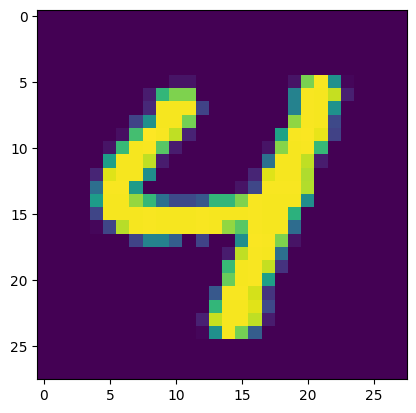

In [21]:
import matplotlib.pyplot as plt
plt.imshow(images[2])

## Create the models

### The Generator

In [25]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Reshape((7, 7, 256)))

  model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))

  return model

In [26]:
generator = make_generator_model()


In [27]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_2 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 7, 7, 128)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_3 (Bat  (None, 7, 7, 128)        

In [34]:
noise = tf.random.normal([1,100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.8801163 ,  0.5149973 ,  0.23682195,  1.5479617 , -1.7580763 ,
        -1.0085685 ,  0.21429351, -0.22454274, -1.2639216 ,  2.3077738 ,
         0.01291271, -0.9240169 , -0.747112  , -0.78671366, -2.0028453 ,
        -1.400583  ,  0.04047751,  0.9889571 , -0.9737754 ,  0.30090782,
        -1.014649  ,  1.3274585 ,  0.89297473,  0.2548364 ,  1.7908401 ,
         1.7075653 ,  0.9277741 ,  0.20586036, -1.0442046 , -0.42405924,
         1.1404237 ,  0.04765157,  1.6028037 ,  0.4753965 , -1.0218207 ,
        -1.5649263 , -1.0351452 ,  0.07916168, -0.74974203, -0.82688546,
        -0.10998276, -0.6719177 , -0.2601459 ,  0.69518507, -0.84608907,
         0.26522252, -0.54495615,  0.880437  ,  0.0633577 , -0.362721  ,
        -0.9893839 ,  1.8307077 , -1.7391071 ,  0.60805535, -2.7741632 ,
        -0.13306023, -1.5134484 ,  0.30532834, -0.1977877 ,  0.6342068 ,
        -0.5915961 ,  1.4075445 ,  0.08408909,  0.06299915, -0.03324752,
 

In [47]:
generated_image = generator(noise, training=False)

In [36]:
generated_image

<tf.Tensor: shape=(1, 28, 28, 1), dtype=float32, numpy=
array([[[[-8.22234608e-04],
         [ 1.22561050e-03],
         [ 1.77372817e-03],
         [ 3.29171820e-03],
         [-2.72852136e-04],
         [-1.14965867e-02],
         [ 1.09031694e-02],
         [ 8.59857444e-03],
         [ 2.69695418e-04],
         [-1.12764891e-02],
         [ 1.19694723e-02],
         [ 7.13611720e-04],
         [ 1.34813134e-04],
         [-1.17036263e-02],
         [-5.04246959e-03],
         [ 2.61758128e-03],
         [-1.22141335e-02],
         [-2.10567564e-03],
         [ 4.33217734e-03],
         [-1.84556879e-02],
         [-7.69886700e-03],
         [-4.74920496e-03],
         [ 4.02217265e-04],
         [-2.86517944e-03],
         [ 2.73613306e-03],
         [-5.85988164e-03],
         [ 1.32096140e-03],
         [ 1.20765669e-03]],

        [[-4.52549895e-04],
         [ 1.24280853e-03],
         [-3.05579044e-03],
         [ 5.31439204e-03],
         [-1.39686745e-03],
         [ 1.83679

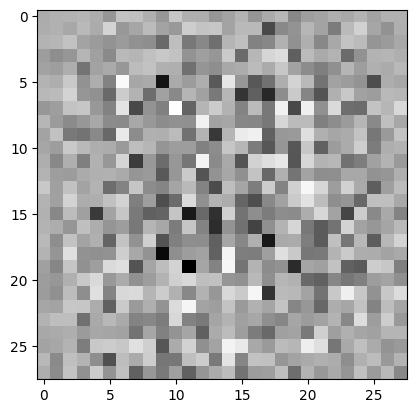

In [48]:
plt.imshow(tf.reshape(generated_image, (28, 28)), cmap='gray')

### Discriminator

In [45]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1))

  return model

In [50]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00157847]], dtype=float32)>